In [ ]:
ГИПОТЕЗА 2
Низкая вовлеченность пользователя: чем больше интервал между первой покупкой и регистрацией, тем ниже изначальная заинтересованность, что увеличивает вероятность возврата. Сравнение по группам интервалов: "до 7 дней" | "после" - есть ли статистически значимые различия target между этими группами.
Стратегия проверки: коэффициент корреляции Пирсона, тест пороговых значений.

In [32]:
import pandas as pd

df = pd.read_csv(r"C:\Users\anastasia.nagoliuk\Desktop\marketplace.csv")

# преобразование в datetime для удобной работы и вычислений
date_columns = ["reg_dt", "first_buy", "first_login"]
df[date_columns] = df[date_columns].apply(pd.to_datetime)

# статистика дат
print("Статистика 'first_login':")
display(df["first_login"].describe())
print("Статистика 'reg_dt':")
display(df["reg_dt"].describe())
print("Статистика 'first_buy':")
display(df["first_buy"].describe())

Статистика 'first_login':


count                            25335
mean     2025-03-13 22:42:28.348134912
min                2024-09-21 00:00:00
25%                2025-02-07 00:00:00
50%                2025-03-23 00:00:00
75%                2025-04-25 00:00:00
max                2025-07-26 00:00:00
Name: first_login, dtype: object

Статистика 'reg_dt':


count                            25331
mean     2024-12-06 07:49:02.844735744
min                2022-10-11 00:00:00
25%                2024-10-12 00:00:00
50%                2025-02-17 00:00:00
75%                2025-04-18 00:00:00
max                2025-07-26 00:00:00
Name: reg_dt, dtype: object

Статистика 'first_buy':


count                            24361
mean     2025-03-11 13:45:36.094577408
min                2023-08-08 00:00:00
25%                2025-02-10 00:00:00
50%                2025-03-25 00:00:00
75%                2025-05-01 00:00:00
max                2025-07-25 00:00:00
Name: first_buy, dtype: object

In [33]:
buys_without_first_buy_dt = df[(df["total_buy"] > 0) & (df["first_buy"].isna())]

print(f"Количество строк, где есть сумма покупок, но нет даты первой покупки: {buys_without_first_buy_dt["user_id"].count()}")

Количество строк, где есть сумма покупок, но нет даты первой покупки: 943


In [34]:
after_dates = ["reg_after_login", "login_after_buy", "reg_after_buy"]

diff_with_first_login_date = df["first_login"] - df["reg_dt"]
df["reg_after_login"] = diff_with_first_login_date.dt.days < 0

diff_with_first_login_date = df["first_buy"] - df["first_login"]
df["login_after_buy"] = diff_with_first_login_date.dt.days < 0

diff_with_reg_date = df["first_buy"] - df["reg_dt"]
df["reg_after_buy"] = diff_with_reg_date.dt.days < 0

print(f"Дата регистрация позже первого логина для {df["reg_after_login"].sum()} записей")
print(f"Дата первого логина позже первой покупки для {df["login_after_buy"].sum()} записей")
print(f"Дата регистрации позже первой покупки для {df["reg_after_buy"].sum()} записей")

display(df[after_dates].head(10))

Дата регистрация позже первого логина для 8597 записей
Дата первого логина позже первой покупки для 10218 записей
Дата регистрации позже первой покупки для 7543 записей


,reg_after_login,login_after_buy,reg_after_buy
0,False,False,False
1,True,False,False
2,True,False,False
3,False,False,False
4,True,False,True
5,False,False,False
6,False,True,False
7,False,True,False
8,False,False,False
9,True,False,False


In [41]:

import pandas as pd

df = pd.read_csv(r"C:\Users\anastasia.nagoliuk\Desktop\marketplace.csv")

df['first_login'] = pd.to_datetime(df['first_login'])
df['reg_dt'] = pd.to_datetime(df['reg_dt'])
df['first_buy'] = pd.to_datetime(df['first_buy'])

df['date_correct?'] = 'ок'

purchase_no_date = (df['total_buy'] > 0) & df['first_buy'].isna()
reg_after_login = df['reg_dt'] > df['first_login']
login_after_buy = df['first_login'] > df['first_buy']
reg_after_buy = df['reg_dt'] > df['first_buy']

invalid_condition = purchase_no_date | reg_after_login | login_after_buy | reg_after_buy

df.loc[invalid_condition, 'date_correct?'] = 'исключаем'

filtered_df = df[df['date_correct?'] == 'ок']

исключаем = (df['date_correct?'] == 'исключаем').sum()
ок = (df['date_correct?'] == 'ок').sum()

print(f"Исключаем: {исключаем}")
print(f"Корректные данные: {ок}")


Исключаем: 17590
Корректные данные: 7745


In [44]:
положительные = (filtered_df['target'] > 0).sum()
отрицательные = (filtered_df['target'] <= 0).sum()

print(f"Строк с положительным target (> 0): {положительные}")
print(f"Строк с отрицательным target (<= 0): {отрицательные}")

Строк с положительным target (> 0): 656
Строк с отрицательным target (<= 0): 7089


In [ ]:
<Так как для бизнеса не столь важно, какое конкретное значение примет target, сколько войдет ли target в порог,
для дальнейшего анализа разобъем target на две категории - отрицательный (покупатель вернул более 30% от стоимости 
своих покупок) и положительный (вернул менее 30% от стоимости покупок)> 

In [47]:

# Количество дней от регистрации до первой покупки
filtered_df['days_to_first_buy'] = (filtered_df['first_buy'] - filtered_df['reg_dt']).dt.days

positive_days = filtered_df[filtered_df['target'] > 0]['days_to_first_buy']
negative_days = filtered_df[filtered_df['target'] <= 0]['days_to_first_buy']

print("Статистика дней до первой покупки для положительного target (> 0):")
print(positive_days.describe())

print(f"\nМинимум: {positive_days.min()} дней")
print(f"Максимум: {positive_days.max()} дней")
print(f"Среднее: {positive_days.mean():.1f} дней")
print(f"Медиана: {positive_days.median()} дней")


print("\nСтатистика дней до первой покупки для отрицательного target (<= 0):")
print(negative_days.describe())

print(f"\nМинимум: {negative_days.min()} дней")
print(f"Максимум: {negative_days.max()} дней")
print(f"Среднее: {negative_days.mean():.1f} дней")
print(f"Медиана: {negative_days.median()} дней")


Статистика дней до первой покупки для положительного target (> 0):
count    654.000000
mean     221.935780
std      261.436259
min        0.000000
25%       13.000000
50%       83.000000
75%      365.000000
max      925.000000
Name: days_to_first_buy, dtype: float64

Минимум: 0.0 дней
Максимум: 925.0 дней
Среднее: 221.9 дней
Медиана: 83.0 дней

Статистика дней до первой покупки для отрицательного target (<= 0):
count    7067.000000
mean      179.763407
std       243.775738
min         0.000000
25%        12.000000
50%        38.000000
75%       292.000000
max       999.000000
Name: days_to_first_buy, dtype: float64

Минимум: 0.0 дней
Максимум: 999.0 дней
Среднее: 179.8 дней
Медиана: 38.0 дней


In [113]:
from scipy.stats import spearmanr

corr_data = filtered_df[['days_to_first_buy', 'target']].dropna()
spearman_corr, p_value = spearmanr(corr_data['days_to_first_buy'], corr_data['target'])

print(f"Коэффициент Спирмена: {spearman_corr:.4f}")
print(f"P-value: {p_value:.6f}")

print()

Коэффициент Спирмена: 0.0264
P-value: 0.020255



In [ ]:
<Так как P-value<0.05, связь между величинами статистически значима
Так как распределение не нормальное для определния корреляции используем коэффициент Спирмена.
Коэффициент Спирмена = 0.0264 < 0,3 => зависимость слабая>

In [122]:

# Анализ пороговых значений

sorted_days = sorted(df_clean['days_to_first_buy'].unique())

results = []
best_threshold = None
best_auc = 0.5

print("Анализ пороговых значений")

# Анализируем пороги с шагом 30 дней
for threshold in sorted_days[::30]:
    if threshold >= 5:
        threshold_int = int(threshold)
        df_clean[f'before_{threshold_int}'] = (df_clean['days_to_first_buy'] <= threshold_int).astype(int)
        
        try:
            auc = roc_auc_score(df_clean['target_negative'], df_clean[f'before_{threshold_int}'])
            
            contingency_table = pd.crosstab(df_clean[f'before_{threshold_int}'], df_clean['target_negative'])
            chi2, p_value, _, _ = stats.chi2_contingency(contingency_table)
            
            before_count = (df_clean[f'before_{threshold_int}'] == 1).sum()
            after_count = (df_clean[f'before_{threshold_int}'] == 0).sum()
            
            neg_before = (df_clean[df_clean[f'before_{threshold_int}'] == 1]['target_negative'] == 1).sum() / before_count * 100
            neg_after = (df_clean[df_clean[f'before_{threshold_int}'] == 0]['target_negative'] == 1).sum() / after_count * 100
            
            results.append({
                'threshold': threshold_int,
                'auc': auc,
                'p_value': p_value,
                'neg_before%': neg_before,
                'neg_after%': neg_after,
                'difference%': neg_after - neg_before,
                'before_count': before_count,
                'after_count': after_count
            })
            
            if auc > best_auc:
                best_auc = auc
                best_threshold = threshold_int
                best_p_value = p_value
                
        except:
            continue

results_df = pd.DataFrame(results)

print("\nТОП-5 порогов по AUC:")
top_5_auc = results_df.sort_values('auc', ascending=False).head(5)
for _, row in top_5_auc.iterrows():
    print(f"Порог {int(row['threshold'])} дней")
    print(f"AUC: {row['auc']:.4f}")
    print(f"p-value: {row['p_value']:.4f}")
    print(f"Отрицательных до порога: {row['neg_before%']:.1f}%")
    print(f"Отрицательных после порога: {row['neg_after%']:.1f}%")
    print(f"Разница: {row['difference%']:.1f}%")
    print(f"Количество до порога: {int(row['before_count'])}")
    print(f"Количество после порога: {int(row['after_count'])}")
    print()



Анализ пороговых значений

ТОП-5 порогов по AUC:
Порог 60 дней
AUC: 0.5530
p-value: 0.0000
Отрицательных до порога: 93.1%
Отрицательных после порога: 89.8%
Разница: -3.3%
Количество до порога: 4149
Количество после порога: 3572

Порог 30 дней
AUC: 0.5448
p-value: 0.0000
Отрицательных до порога: 93.0%
Отрицательных после порога: 90.2%
Разница: -2.8%
Количество до порога: 3644
Количество после порога: 4077

Порог 150 дней
AUC: 0.5447
p-value: 0.0000
Отрицательных до порога: 92.6%
Отрицательных после порога: 89.6%
Разница: -3.0%
Количество до порога: 4953
Количество после порога: 2768

Порог 180 дней
AUC: 0.5440
p-value: 0.0000
Отрицательных до порога: 92.6%
Отрицательных после порога: 89.5%
Разница: -3.1%
Количество до порога: 5120
Количество после порога: 2601

Порог 120 дней
AUC: 0.5426
p-value: 0.0000
Отрицательных до порога: 92.6%
Отрицательных после порога: 89.8%
Разница: -2.8%
Количество до порога: 4758
Количество после порога: 2963



In [ ]:
<Так как p-value < 0.05, все пороги статичтисеки значимы. 
Наибольший эффект наблюдается при пороге в первые 60 дней. Вероятность отрицательного target у пользователей, 
совершивших покупку в указанный диапазон на 3.3% выше. Однако разница не существенная.

Проведенные тесты указывают на то, что гипотеза 2 не является ключевой при анализе взаимосвязей между возвратми
и прочими переменными.>

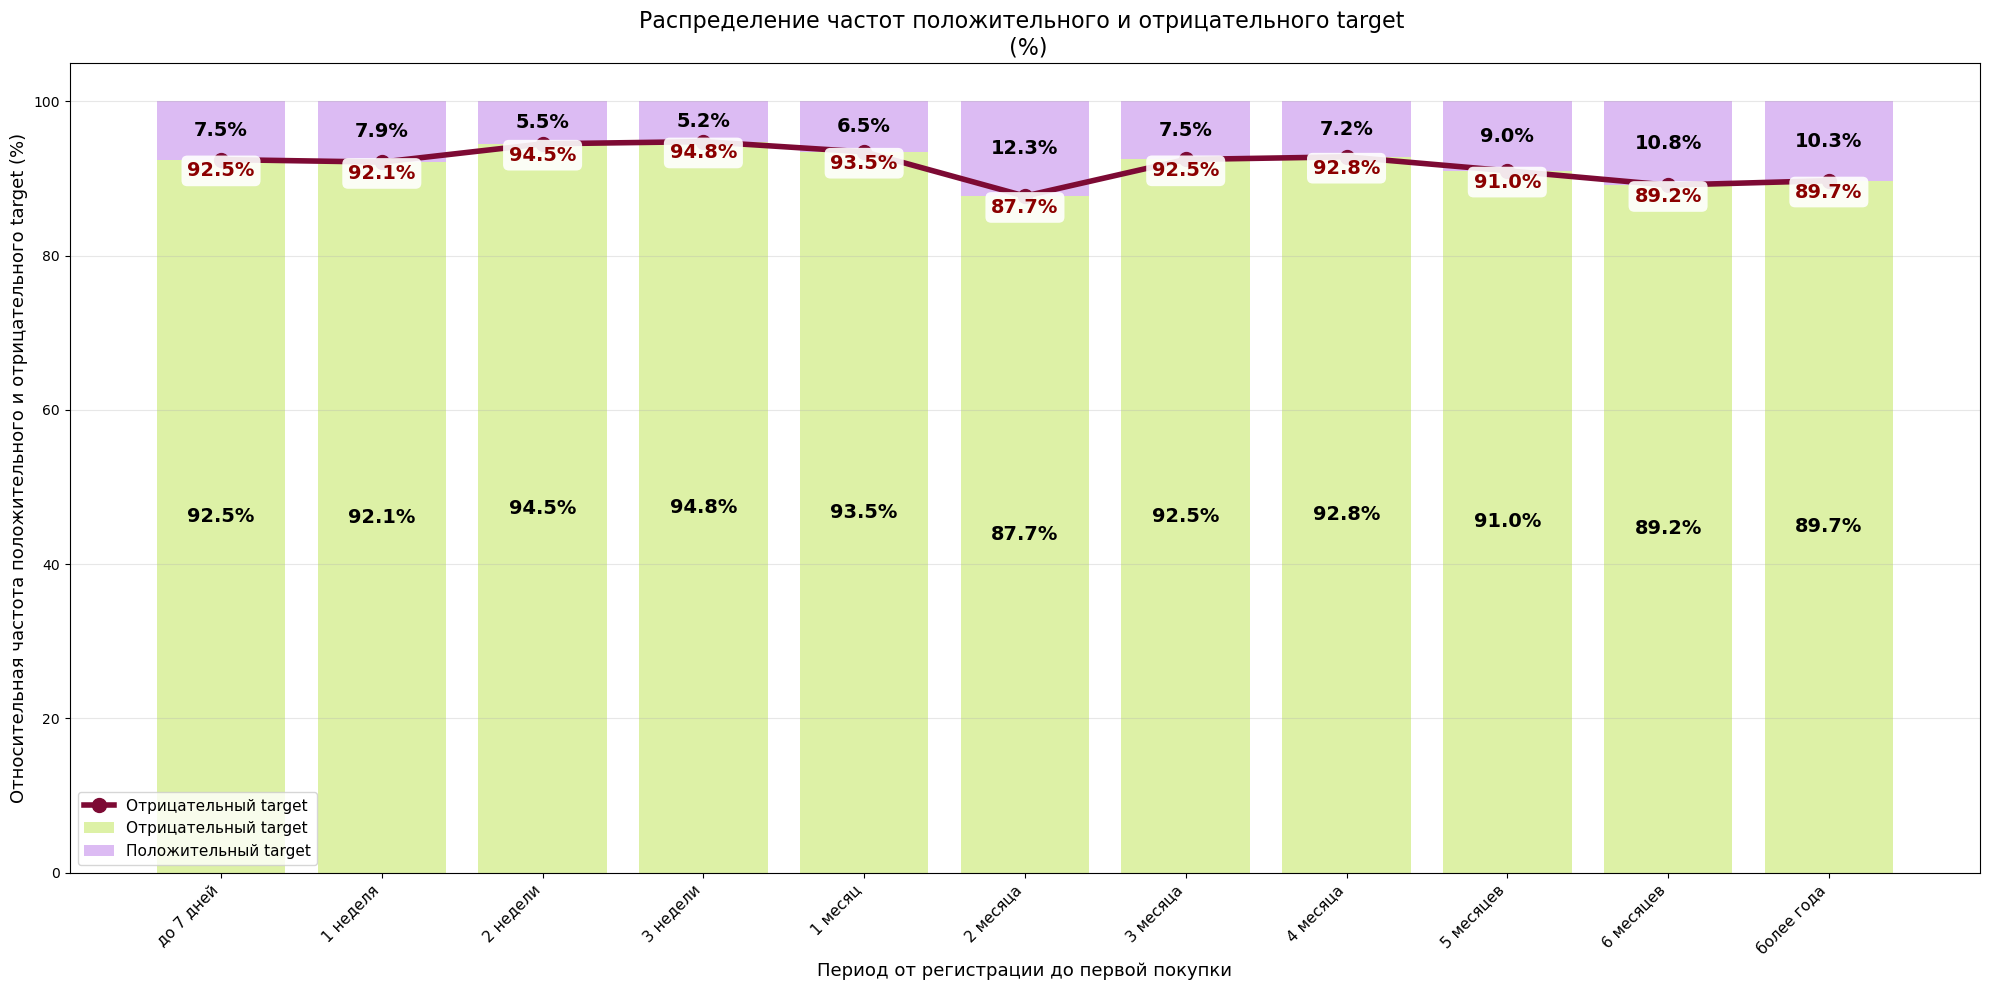

In [104]:

fig, ax = plt.subplots(figsize=(20, 10))

x = np.arange(len(period_comparison.index))

light_green = '#D5EE90'  
light_purple = '#D4AAf0' 
red_line = '#7D0A34'     

bar_width = 0.8
bars_neg = ax.bar(x, period_comparison['Отрицательных %'], bar_width, 
                  label='Отрицательный target', color=light_green, alpha=0.8, edgecolor='none')
bars_pos = ax.bar(x, period_comparison['Положительных %'], bar_width, 
                  bottom=period_comparison['Отрицательных %'],
                  label='Положительный target', color=light_purple, alpha=0.8, edgecolor='none')

line_trend, = ax.plot(x, period_comparison['Отрицательных %'], 
                      color=red_line, marker='o', linewidth=4, markersize=10,
                      label='Отрицательный target')

ax.set_title('Распределение частот положительного и отрицательного target \n (%)', fontsize=16)
ax.set_xlabel('Период от регистрации до первой покупки', fontsize=13)
ax.set_ylabel('Относительная частота положительного и отрицательного target (%)', fontsize=13)

ax.set_xticks(x)
ax.set_xticklabels(period_comparison.index, rotation=45, ha='right', fontsize=11)

ax.grid(True, alpha=0.3, axis='y')
ax.legend(fontsize=11)

for i, (neg_pct, pos_pct, total) in enumerate(zip(period_comparison['Отрицательных %'], 
                                                   period_comparison['Положительных %'],
                                                   period_comparison['Всего строк'])):
    if total > 0:
        ax.text(i, neg_pct/2, f'{neg_pct:.1f}%', ha='center', va='center', 
                fontsize=14, color='black', fontweight='bold')
        ax.text(i, neg_pct + pos_pct/2, f'{pos_pct:.1f}%', ha='center', va='center', 
                fontsize=14, color='black', fontweight='bold')
        
for i, neg_pct in enumerate(period_comparison['Отрицательных %']):
    offset_y = -15 if neg_pct > 50 else 15
    
    ax.annotate(f'{neg_pct:.1f}%', 
                xy=(i, neg_pct), 
                xytext=(0, offset_y),
                textcoords='offset points',
                ha='center', 
                va='top' if offset_y > 0 else 'bottom',
                fontsize=14, color='darkred',
                fontweight='bold',
                bbox=dict(boxstyle='round,pad=0.3', facecolor='white', alpha=0.9, edgecolor='none'))

plt.tight_layout()
plt.show()


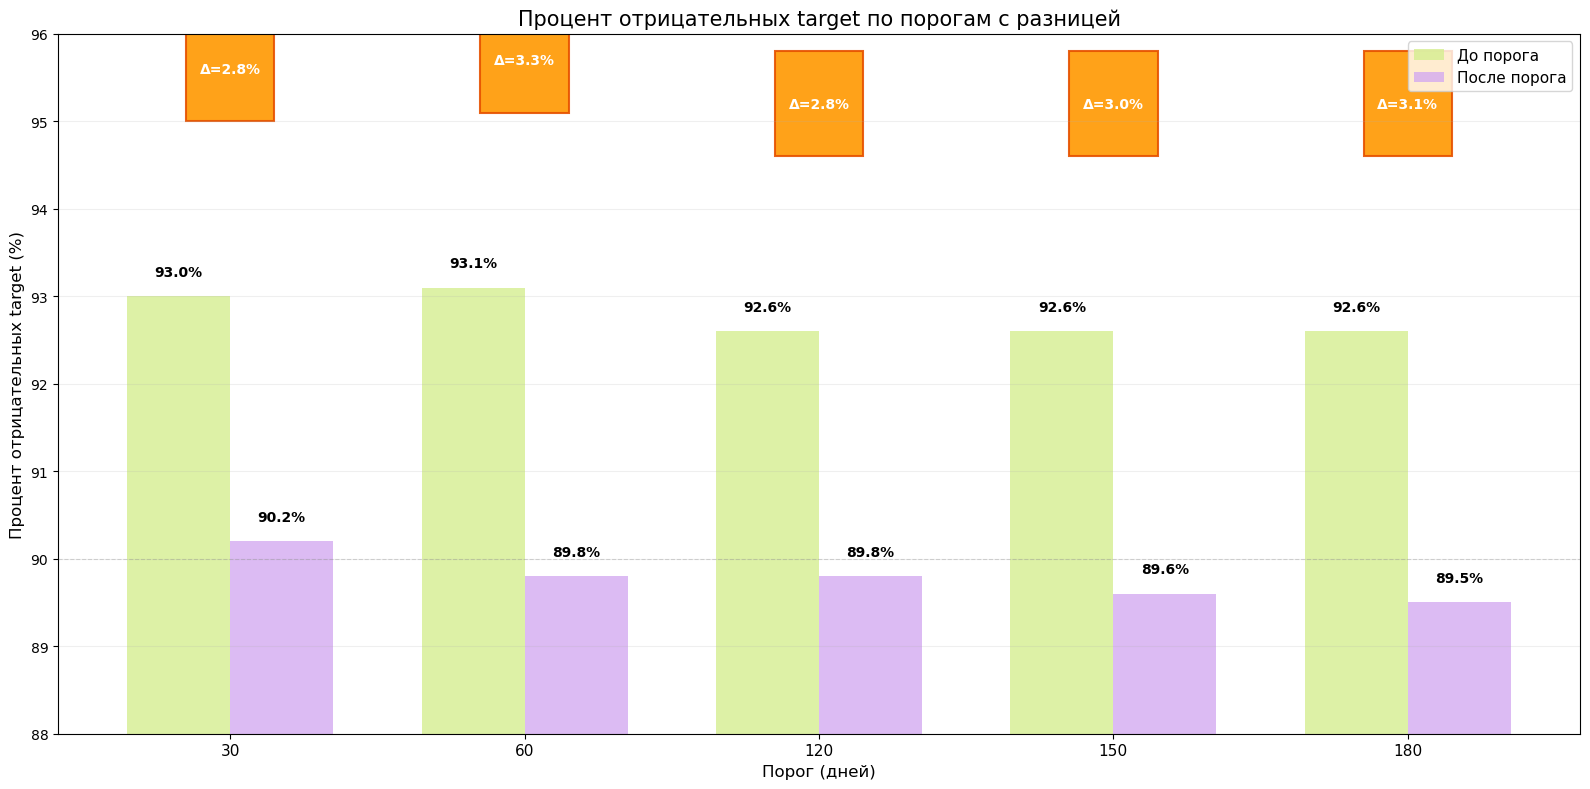

In [139]:

threshold_data = pd.DataFrame({
    'Порог (дней)': [60, 30, 150, 180, 120],
    'До порога %': [93.1, 93.0, 92.6, 92.6, 92.6],
    'После порога %': [89.8, 90.2, 89.6, 89.5, 89.8]
})

threshold_data['Дельта %'] = threshold_data['До порога %'] - threshold_data['После порога %']
threshold_data = threshold_data.sort_values('Порог (дней)')

fig, ax = plt.subplots(figsize=(16, 8))

x = np.arange(len(threshold_data))
width = 0.35

bars_before = ax.bar(x - width/2, threshold_data['До порога %'], width,
                     label='До порога', color='#D5EE90', alpha=0.8)

bars_after = ax.bar(x + width/2, threshold_data['После порога %'], width,
                    label='После порога', color='#D4AAf0', alpha=0.8)

ax.set_title('Процент отрицательных target по порогам с разницей', fontsize=15)
ax.set_xlabel('Порог (дней)', fontsize=12)
ax.set_ylabel('Процент отрицательных target (%)', fontsize=12)
ax.set_xticks(x)
ax.set_xticklabels(threshold_data['Порог (дней)'], fontsize=11)

ax.legend(fontsize=11)
ax.grid(True, alpha=0.2, axis='y')
ax.axhline(y=90, color='gray', linestyle='--', alpha=0.3, linewidth=0.8)
ax.set_ylim(88, 96)

for i, (before, after, delta) in enumerate(zip(threshold_data['До порога %'], 
                                               threshold_data['После порога %'],
                                               threshold_data['Дельта %'])):
    
    ax.text(i - width/2, before + 0.2, f'{before:.1f}%', 
            ha='center', va='bottom', fontsize=10, fontweight='bold', color='black')
    
    ax.text(i + width/2, after + 0.2, f'{after:.1f}%', 
            ha='center', va='bottom', fontsize=10, fontweight='bold', color='black')
    
    mid_x = i
    max_val = max(before, after)
    
    rect = plt.Rectangle((mid_x - 0.15, max_val + 2), 0.3, 1.2,
                         facecolor='#FF9800', alpha=0.9, edgecolor='#E65100', linewidth=1.5)
    ax.add_patch(rect)
    
    ax.text(mid_x, max_val + 2.6, f'Δ={delta:.1f}%', 
            ha='center', va='center', fontsize=10, fontweight='bold', color='white')

plt.tight_layout()
plt.show()
